In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import numpy as np

# Define the parameter grid
param_grid = {
    'n_neighbors': [5, 9, 21, 51],
    'metric': ['euclidean', 'manhattan', 'cosine'],
}

def run_knn(results, X_encoded, Y, file_name):
    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_encoded)

    # Split dataset
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

    bestmodel = None
    bestscore = -1
    bestk = None
    best_metric = None

    # Try all combinations of k and metric
    for k in param_grid['n_neighbors']:
        for m in param_grid['metric']:
            model = KNeighborsClassifier(n_neighbors=k, metric=m)
            model.fit(X_train, y_train)

            y_pred = model.predict(X_test)
            f1 = round(f1_score(y_test, y_pred, average='micro'), 2)

            print(f"Results with K={k}, Metric={m}: F1 Score = {f1}")
            cm = confusion_matrix(y_test, y_pred)

            results[(k, m)] = (f1, cm)

            if f1 > bestscore:
                bestscore = f1
                bestmodel = model
                bestk = k
                best_metric = m

    if bestmodel is not None:
        print(f"\nBest F1 Score: {bestscore} with K={bestk}, Metric={best_metric}")

        # Confusion matrix
        plt.figure(figsize=(8, 10))
        disp = ConfusionMatrixDisplay(confusion_matrix=results[(bestk, best_metric)][1],
                                      display_labels=bestmodel.classes_)
        disp.plot(cmap='Blues')
        plt.title(f"KNN Confusion Matrix (K={bestk}, Metric={best_metric})")
        plt.savefig(file_name + "_conf.png", bbox_inches='tight')
        plt.show()

        # Learning curve
        plt.figure(figsize=(8, 6))
        train_sizes, train_scores, test_scores = learning_curve(
            bestmodel, X_scaled, Y, cv=5, scoring='f1_micro', n_jobs=-1,
            train_sizes=np.linspace(0.1, 1.0, 10), shuffle=True, random_state=42
        )
        train_scores_mean = np.mean(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores, axis=1)

        plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training F1 score")
        plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation F1 score")
        plt.title(f"Learning Curve (K={bestk}, Metric={best_metric})")
        plt.xlabel("Training Examples")
        plt.ylabel("F1 Score (weighted)")
        plt.legend(loc="best")
        plt.grid()
        plt.tight_layout()
        plt.savefig(file_name + "_learning_curve.png", bbox_inches='tight')
        plt.show()

def graph_knn_results(results, file_name_base):
    plt.figure(figsize=(7, 5))

    # Extract and group results by metric
    metrics = sorted(set(metric for (_, metric) in results))
    for metric in metrics:
        k_vals = []
        f1_vals = []
        for (k, m), (f1, _) in results.items():
            if m == metric:
                k_vals.append(k)
                f1_vals.append(f1)
        # Sort for consistent plotting
        sorted_pairs = sorted(zip(k_vals, f1_vals))
        k_vals, f1_vals = zip(*sorted_pairs)
        plt.plot(k_vals, f1_vals, marker='o', linestyle='-', linewidth=2, label=metric)

    plt.title('F1 Score vs K for Different Distance Metrics')
    plt.xlabel('K (Number of Neighbors)')
    plt.ylabel('F1 Score (Weighted)')
    plt.legend(title='Metric')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(file_name_base, bbox_inches='tight')
    plt.show()


Results with K=5, Metric=euclidean: F1 Score = 0.96
Results with K=5, Metric=manhattan: F1 Score = 0.96
Results with K=5, Metric=cosine: F1 Score = 0.96
Results with K=9, Metric=euclidean: F1 Score = 0.96
Results with K=9, Metric=manhattan: F1 Score = 0.97
Results with K=9, Metric=cosine: F1 Score = 0.96
Results with K=21, Metric=euclidean: F1 Score = 0.96
Results with K=21, Metric=manhattan: F1 Score = 0.96
Results with K=21, Metric=cosine: F1 Score = 0.96
Results with K=51, Metric=euclidean: F1 Score = 0.96
Results with K=51, Metric=manhattan: F1 Score = 0.96
Results with K=51, Metric=cosine: F1 Score = 0.96

Best F1 Score: 0.97 with K=9, Metric=manhattan


<Figure size 800x1000 with 0 Axes>

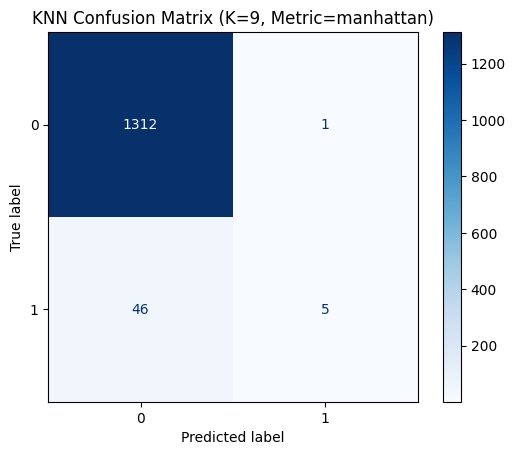

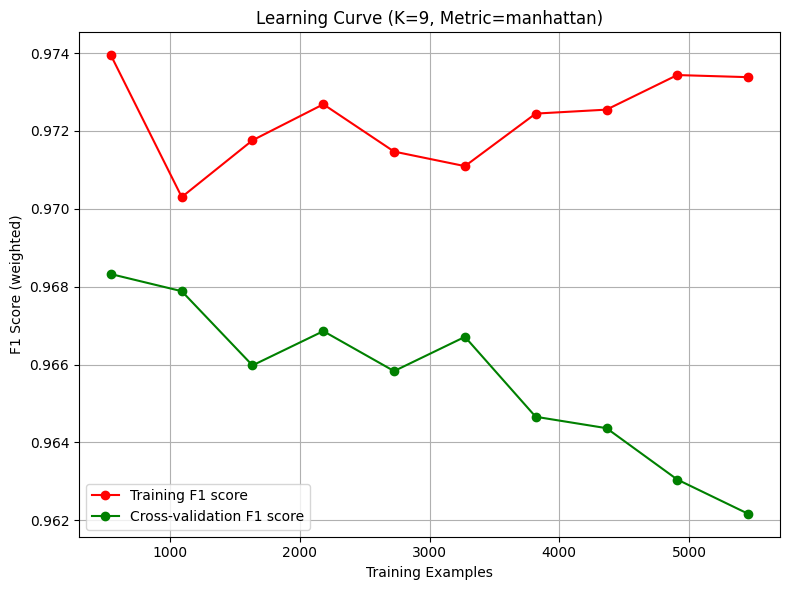

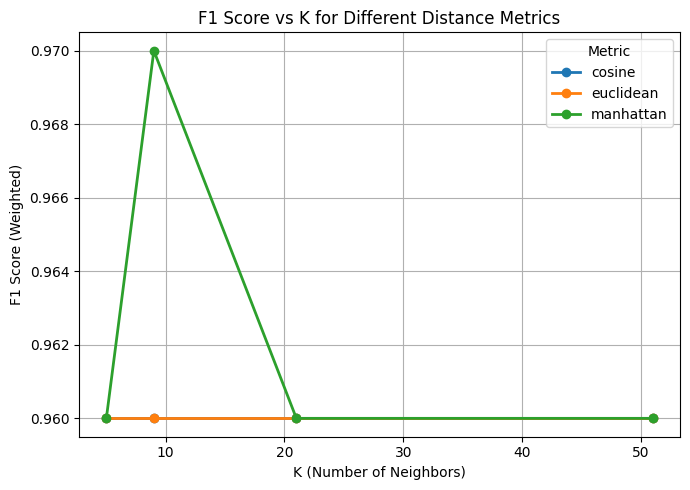

In [5]:
import pandas as pd

df = pd.read_csv('bankruptcy_data.csv')

X = df.drop(['Bankrupt?', ' Net Income Flag', ' Liability-Assets Flag'], axis=1)
Y = df['Bankrupt?']

# Run the algorithm
full_results = {}
run_knn(full_results, X, Y, "bankruptcy_knn_")
graph_knn_results(full_results, "bankruptcy_knn_")
